In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import anndata as ad
import scanpy as sc

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP

from scroutines import powerplots

import importlib
importlib.reload(powerplots)
from scroutines import basicu
from scroutines.miscu import is_in_polygon

import utils_merfish

In [2]:
np.random.seed(0)

In [3]:
# functions (the teacher wrote for you to use later)
def rot2d(x, y, theta, unit='degree'):
    """ rotate data points defined by `x` and `y` by `theta` degree
    """
    a = np.vstack([x,y]).T
    if unit == 'degree':
        theta = theta*np.pi/180 # convert to radian

    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    ar = a.dot(R.T)
    return ar[:,0], ar[:,1]

def st_scatter(x, y, gexp=None, vmax_p=98, unit_norm=False, 
               title='', s=1, cbar_label='', output='', cmap='rocket_r', axis_off=True, 
               vmin=None, **cbar_kwargs):
    """customized scatter plot -- yesterday's progress
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
  
    fig, ax = plt.subplots(figsize=(10,8))
    if gexp is not None:
        vmax = np.percentile(gexp, vmax_p)
        if unit_norm:
            rgexp = gexp/vmax
            g = ax.scatter(x, y, c=rgexp, s=s, edgecolor='none', vmin=vmin, vmax=1, cmap=cmap, rasterized=True)
            fig.colorbar(g, label=cbar_label, shrink=0.3, **cbar_kwargs)
            title = title + f" (max {vmax:.2g} at {vmax_p:.2g} pctl)"
        else:
            g = ax.scatter(x, y, c=gexp, s=s, edgecolor='none', vmin=vmin, vmax=vmax, cmap=cmap, rasterized=True)
            fig.colorbar(g, label=cbar_label, shrink=0.3, **cbar_kwargs)
    else:
        g = ax.scatter(x, y, s=s, edgecolor='none', cmap=cmap, rasterized=True)
  
    if axis_off:
        ax.axis('off')
    ax.set_title(title)
    ax.set_aspect('equal')
  
    if output:
        powerplots.savefig_autodate(fig, output)
        
    return 

def st_scatter_ax(ax, x, y, gexp=None, vmax_p=98, unit_norm=False, 
               title='', s=1, cbar_label='', cmap='rocket_r', axis_off=True, 
               vmin=None, **cbar_kwargs):
    """customized scatter plot -- yesterday's progress
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
  
    if gexp is not None:
        vmax = np.percentile(gexp, vmax_p)
        if unit_norm:
            rgexp = gexp/vmax
            g = ax.scatter(x, y, c=rgexp, s=s, edgecolor='none', vmin=vmin, vmax=1, cmap=cmap, rasterized=True)
            fig.colorbar(g, label=cbar_label, shrink=0.3, **cbar_kwargs)
            title = title + f" (max {vmax:.2g} at {vmax_p:.2g} pctl)"
        else:
            g = ax.scatter(x, y, c=gexp, s=s, edgecolor='none', vmin=vmin, vmax=vmax, cmap=cmap, rasterized=True)
            fig.colorbar(g, label=cbar_label, shrink=0.3, **cbar_kwargs)
    else:
        g = ax.scatter(x, y, s=s, edgecolor='none', cmap=cmap, rasterized=True)
  
    if axis_off:
        ax.axis('off')
    ax.set_title(title)
    ax.set_aspect('equal')
  
    return 

# visualize clusters
def plot_cluster(clsts, x, y, ux, uy, s=1, axis_off=True):
    """this assumes `clsts` is a integer that starts from 0
    """
    from matplotlib import colors
  
    unq_clsts, inv = np.unique(clsts, return_inverse=True)
    n_unq = len(unq_clsts)
    # colors = np.array(sns.color_palette('husl', n_unq))
    # c_vec = colors[inv]
  
    cmap = plt.cm.jet
    norm = colors.BoundaryNorm(np.arange(-0.5, n_unq, 1), cmap.N)
  
    fig, axs = plt.subplots(1, 2, figsize=(8*2,6))
    
    ax = axs[0]
    g = ax.scatter(x, y, norm=norm, cmap=cmap, c=clsts, s=s, edgecolor='none')
    ax.set_title('XY (spatial distribution)')
    ax.set_aspect('equal')
    if axis_off:
        ax.axis('off')
    
    ax = axs[1]
    ax.scatter(ux, uy, norm=norm, cmap=cmap, c=clsts, s=s, edgecolor='none')
    ax.set_title('UMAP (molecular similarity)')
    ax.set_aspect('equal')
    if axis_off:
        ax.axis('off')
  
    fig.colorbar(g, ax=ax, label='clusters', ticks=np.arange(n_unq), shrink=0.7)
    return fig, axs

In [13]:
def binning_pipe(adata, n=20, layer='lnorm', bin_type='depth_bin'):
    """
    """
    assert bin_type in ['depth_bin', 'width_bin']
    # bin it 
    depth_bins, depth_binned = utils_merfish.binning(adata.obs['depth'].values, n)
    width_bins, width_binned = utils_merfish.binning(adata.obs['width'].values, n)

    norm_ = pd.DataFrame(adata.layers[layer], columns=adata.var.index)
    norm_['depth_bin'] = depth_binned
    norm_['width_bin'] = width_binned
    
    norm_mean = norm_.groupby(bin_type).mean()
    norm_sem  = norm_.groupby(bin_type).sem()
    norm_std  = norm_.groupby(bin_type).std()
    norm_n    = norm_[bin_type].value_counts(sort=False)

    return norm_mean, norm_sem, norm_std, norm_n, depth_binned, width_binned, depth_bins, width_bins

In [4]:
outdir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240228"
outdatadir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish"
!mkdir -p $outdir

In [5]:
adata = ad.read('/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/samp231114_reg1_ctxglut_240301.h5ad')
# adata = adata[adata.obs['x'] > 7000]
adata

AnnData object with n_obs × n_vars = 6205 × 500
    obs: 'x', 'y', 'gncov', 'fpcov', 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'DreO_raw', 'DreO_high_pass', 'Cre_raw', 'Cre_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'FlpO_raw', 'FlpO_high_pass', 'Pvalb_raw', 'Pvalb_high_pass', 'Sst_raw', 'Sst_high_pass', 'Fth1_raw', 'Fth1_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'leiden_r0.1', 'depth', 'width'
    uns: 'leiden', 'neighbors'
    obsm: 'blanks', 'pca', 'umap'
    layers: 'norm'
    obsp: 'connectivities', 'distances'

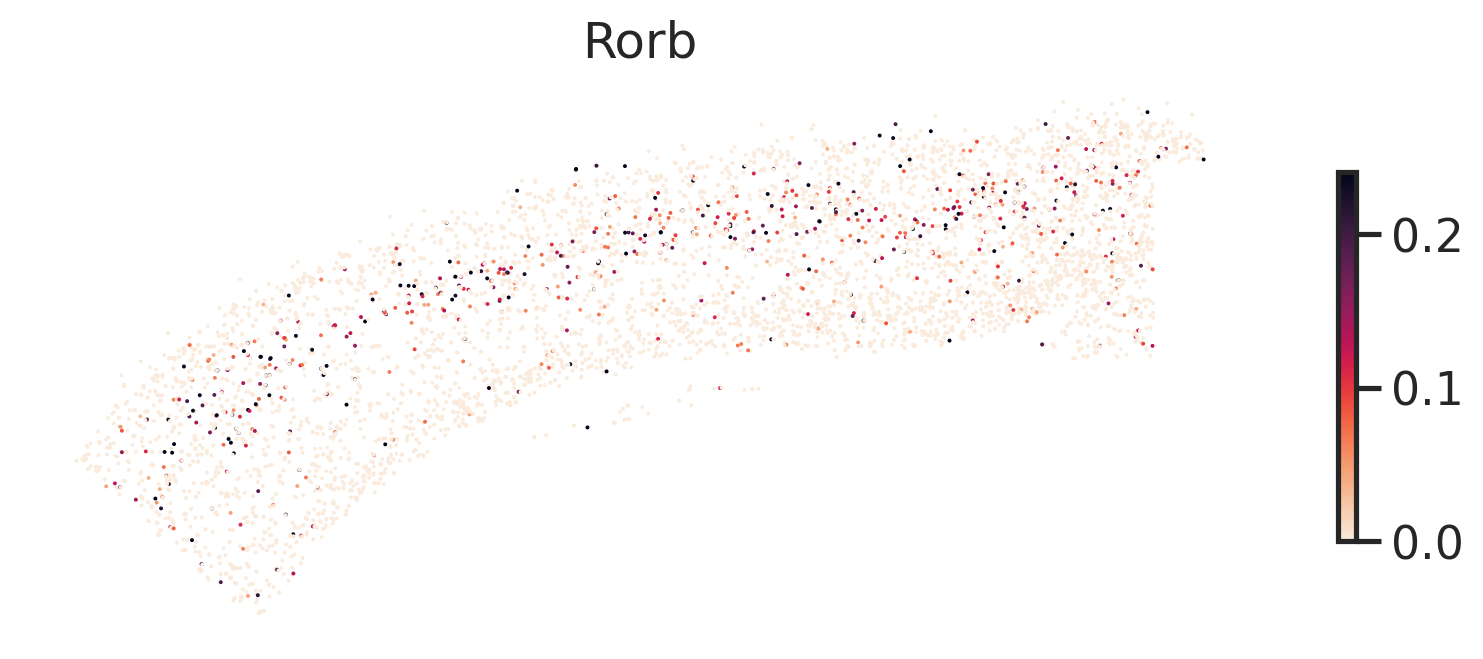

In [6]:
gn = 'Rorb'

x = adata.obs['x']
y = adata.obs['y']
ux = adata.obsm['umap'][:,0]
uy = adata.obsm['umap'][:,1]

g = np.log10(1+adata[:,gn].layers['norm'])
st_scatter(x, y, gexp=g, s=2, title=gn)



# st_scatter(x, y, gexp=g, s=2, title=gn, unit_norm=True)
# st_scatter(ux, uy, gexp=g, s=2, title=gn)

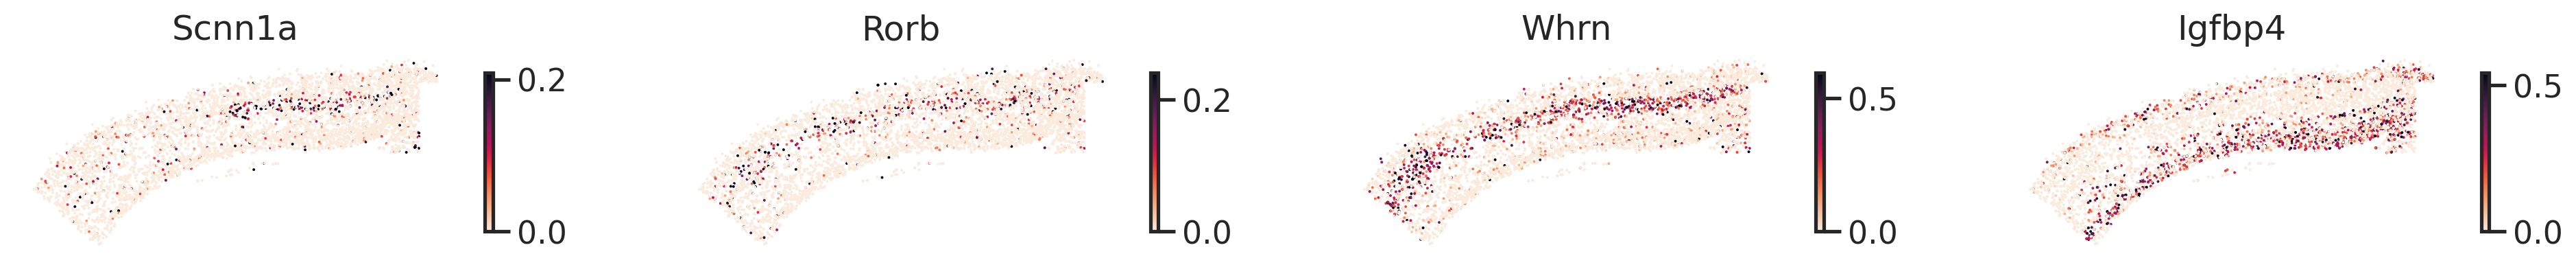

In [7]:

gns = ['Scnn1a', 'Rorb', 'Whrn', 'Igfbp4']
x = adata.obs['x']
y = adata.obs['y']
n = len(gns)

fig, axs = plt.subplots(1,n,figsize=(n*6,1*5))
for ax, gn in zip(axs, gns):
    # gn = 'Scnn1a'
    g = np.log10(1+adata[:,gn].layers['norm'])
    st_scatter_ax(ax, x, y, gexp=g, s=2, title=gn)
    
plt.show()

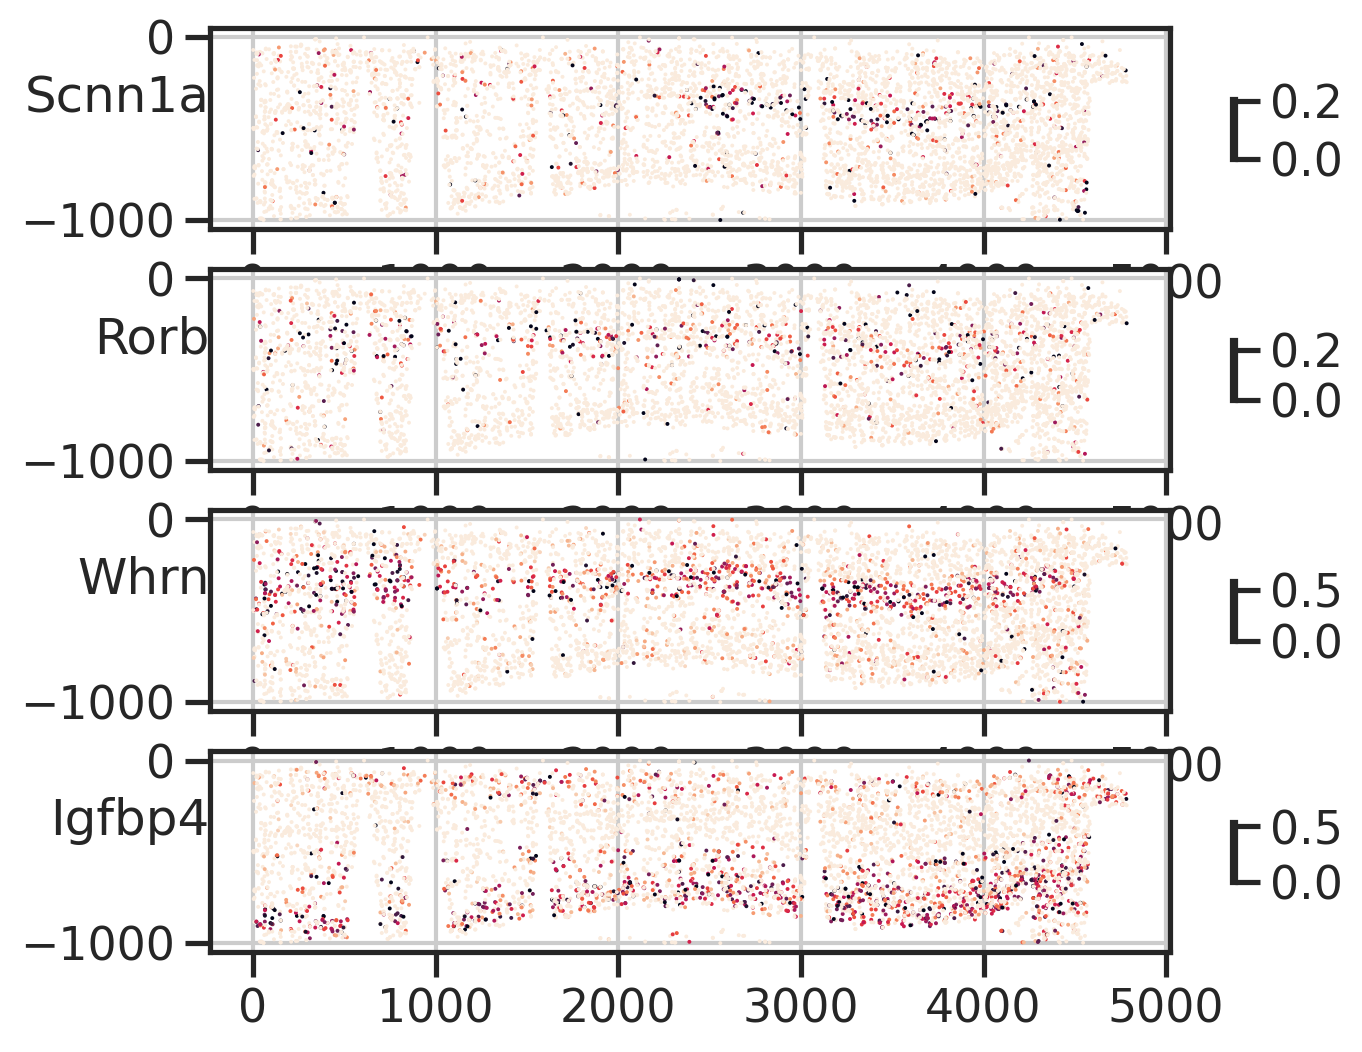

In [8]:


gns = ['Scnn1a', 'Rorb', 'Whrn', 'Igfbp4']
x = adata.obs['width']
y = -adata.obs['depth']
n = len(gns)

fig, axs = plt.subplots(n,1,figsize=(1*8,n*1.5))
for ax, gn in zip(axs, gns):
    # gn = 'Scnn1a'
    g = np.log10(1+adata[:,gn].layers['norm'])
    st_scatter_ax(ax, x, y, gexp=g, s=2, title="")
    ax.set_title(gn, loc='left', ha='right', y=0.5)
    ax.grid(True)
    ax.axis('on')
    
plt.show()

In [9]:
bound_l, bound_r, bound_d = 2400, 4400, 400

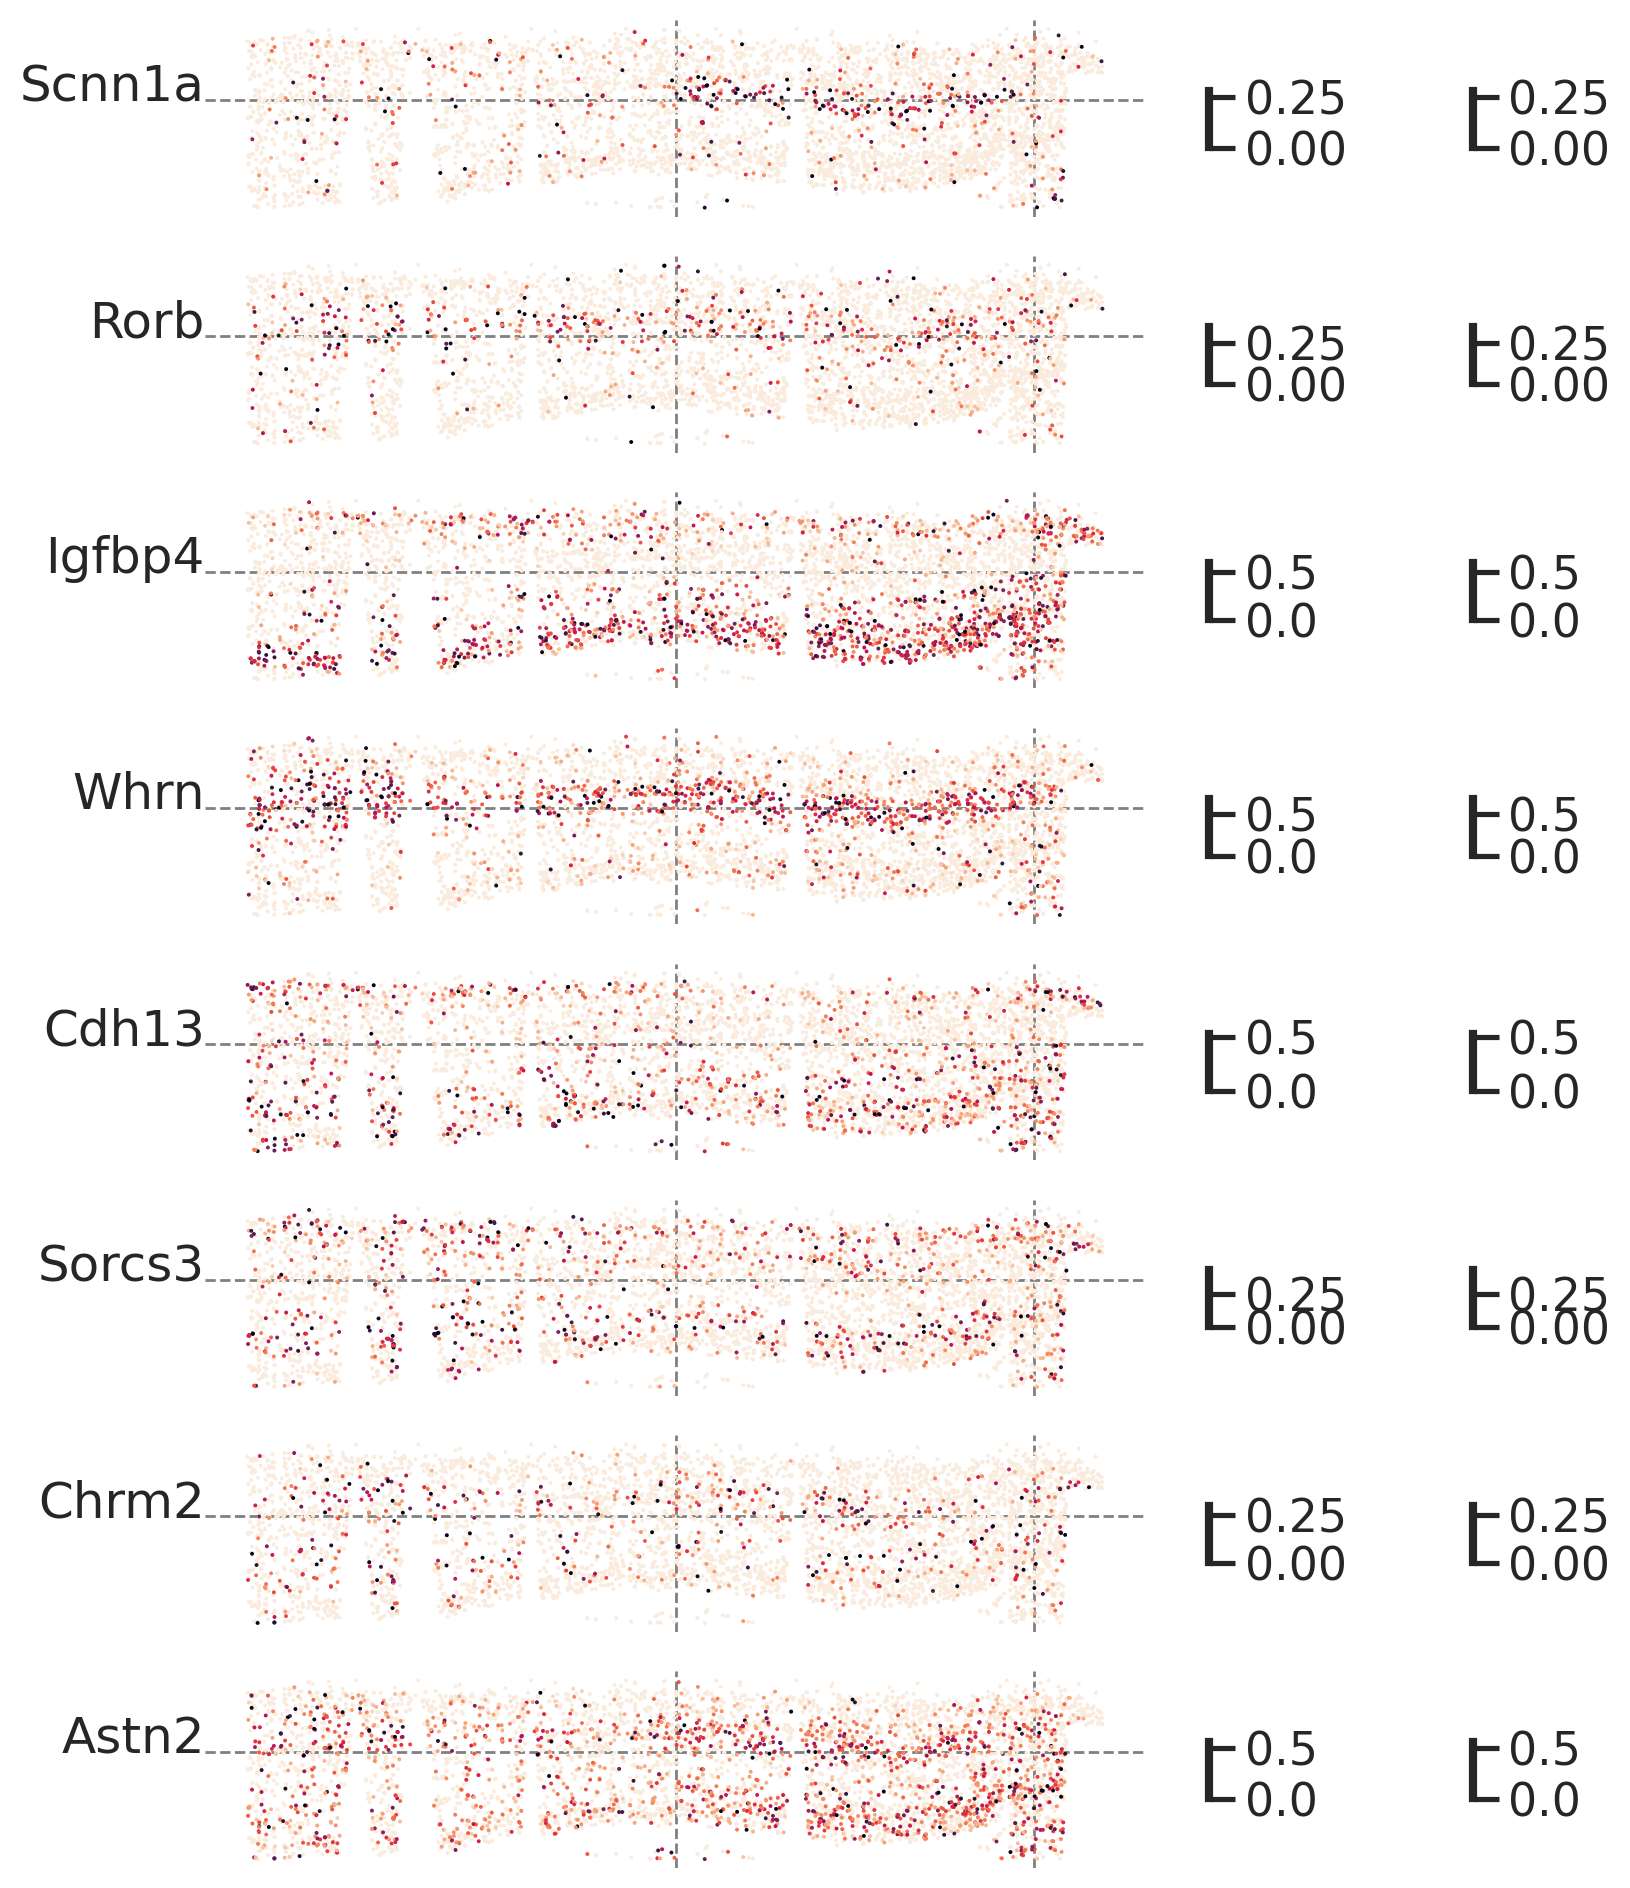

In [10]:
gns = ['Scnn1a', 'Rorb', 'Igfbp4', 'Whrn', 'Cdh13', 'Sorcs3', 'Chrm2', 'Astn2']
x = adata.obs['width']
y = -adata.obs['depth']
n = len(gns)

fig, axs = plt.subplots(n,1,figsize=(1*10,n*1.5))
for ax, gn in zip(axs, gns):
    # gn = 'Scnn1a'
    g = np.log10(1+adata[:,gn].layers['norm']).reshape(-1,)
    
    vmax = np.percentile(g, 99)
    vmin = np.percentile(g,  5)
    cond = g > 1e-5
    
    utils_merfish.st_scatter_ax(fig, ax, x[~cond], y[~cond], gexp=g[~cond], s=2, title='', vmin=vmin, vmax=vmax, cmap='rocket_r') #, axis_off=False)
    utils_merfish.st_scatter_ax(fig, ax,  x[cond],  y[cond],  gexp=g[cond], s=2, title='', vmin=vmin, vmax=vmax, cmap='rocket_r') #, axis_off=False)
    
    ax.set_title(gn, loc='left', ha='right', y=0.5)
    ax.axhline(-bound_d, linestyle='--', linewidth=1, color='gray', zorder=0)
    ax.axvline( bound_l, linestyle='--', linewidth=1, color='gray', zorder=0)
    ax.axvline( bound_r, linestyle='--', linewidth=1, color='gray', zorder=0)
    # ax.grid(True)
    # ax.axis('on')
    
plt.show()

In [11]:
cond_v1l23 = np.all([
    adata.obs['width'] > bound_l,
    adata.obs['width'] < bound_r,
    adata.obs['depth'] < bound_d,
], axis=0)

adatasub = adata[cond_v1l23]
adata, adatasub

(AnnData object with n_obs × n_vars = 6205 × 500
     obs: 'x', 'y', 'gncov', 'fpcov', 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'DreO_raw', 'DreO_high_pass', 'Cre_raw', 'Cre_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'FlpO_raw', 'FlpO_high_pass', 'Pvalb_raw', 'Pvalb_high_pass', 'Sst_raw', 'Sst_high_pass', 'Fth1_raw', 'Fth1_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'leiden_r0.1', 'depth', 'width'
     uns: 'leiden', 'neighbors'
     obsm: 'blanks', 'pca', 'umap'
     layers: 'norm'
     obsp: 'connectivities', 'distances',
 View of AnnData object with n_obs × n_vars = 1192 × 500
     obs: 'x', 'y', 'gncov', 'fpcov', 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'DreO_raw', 'DreO_high_pass', 'Cre_raw', 'Cre_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'FlpO_raw',

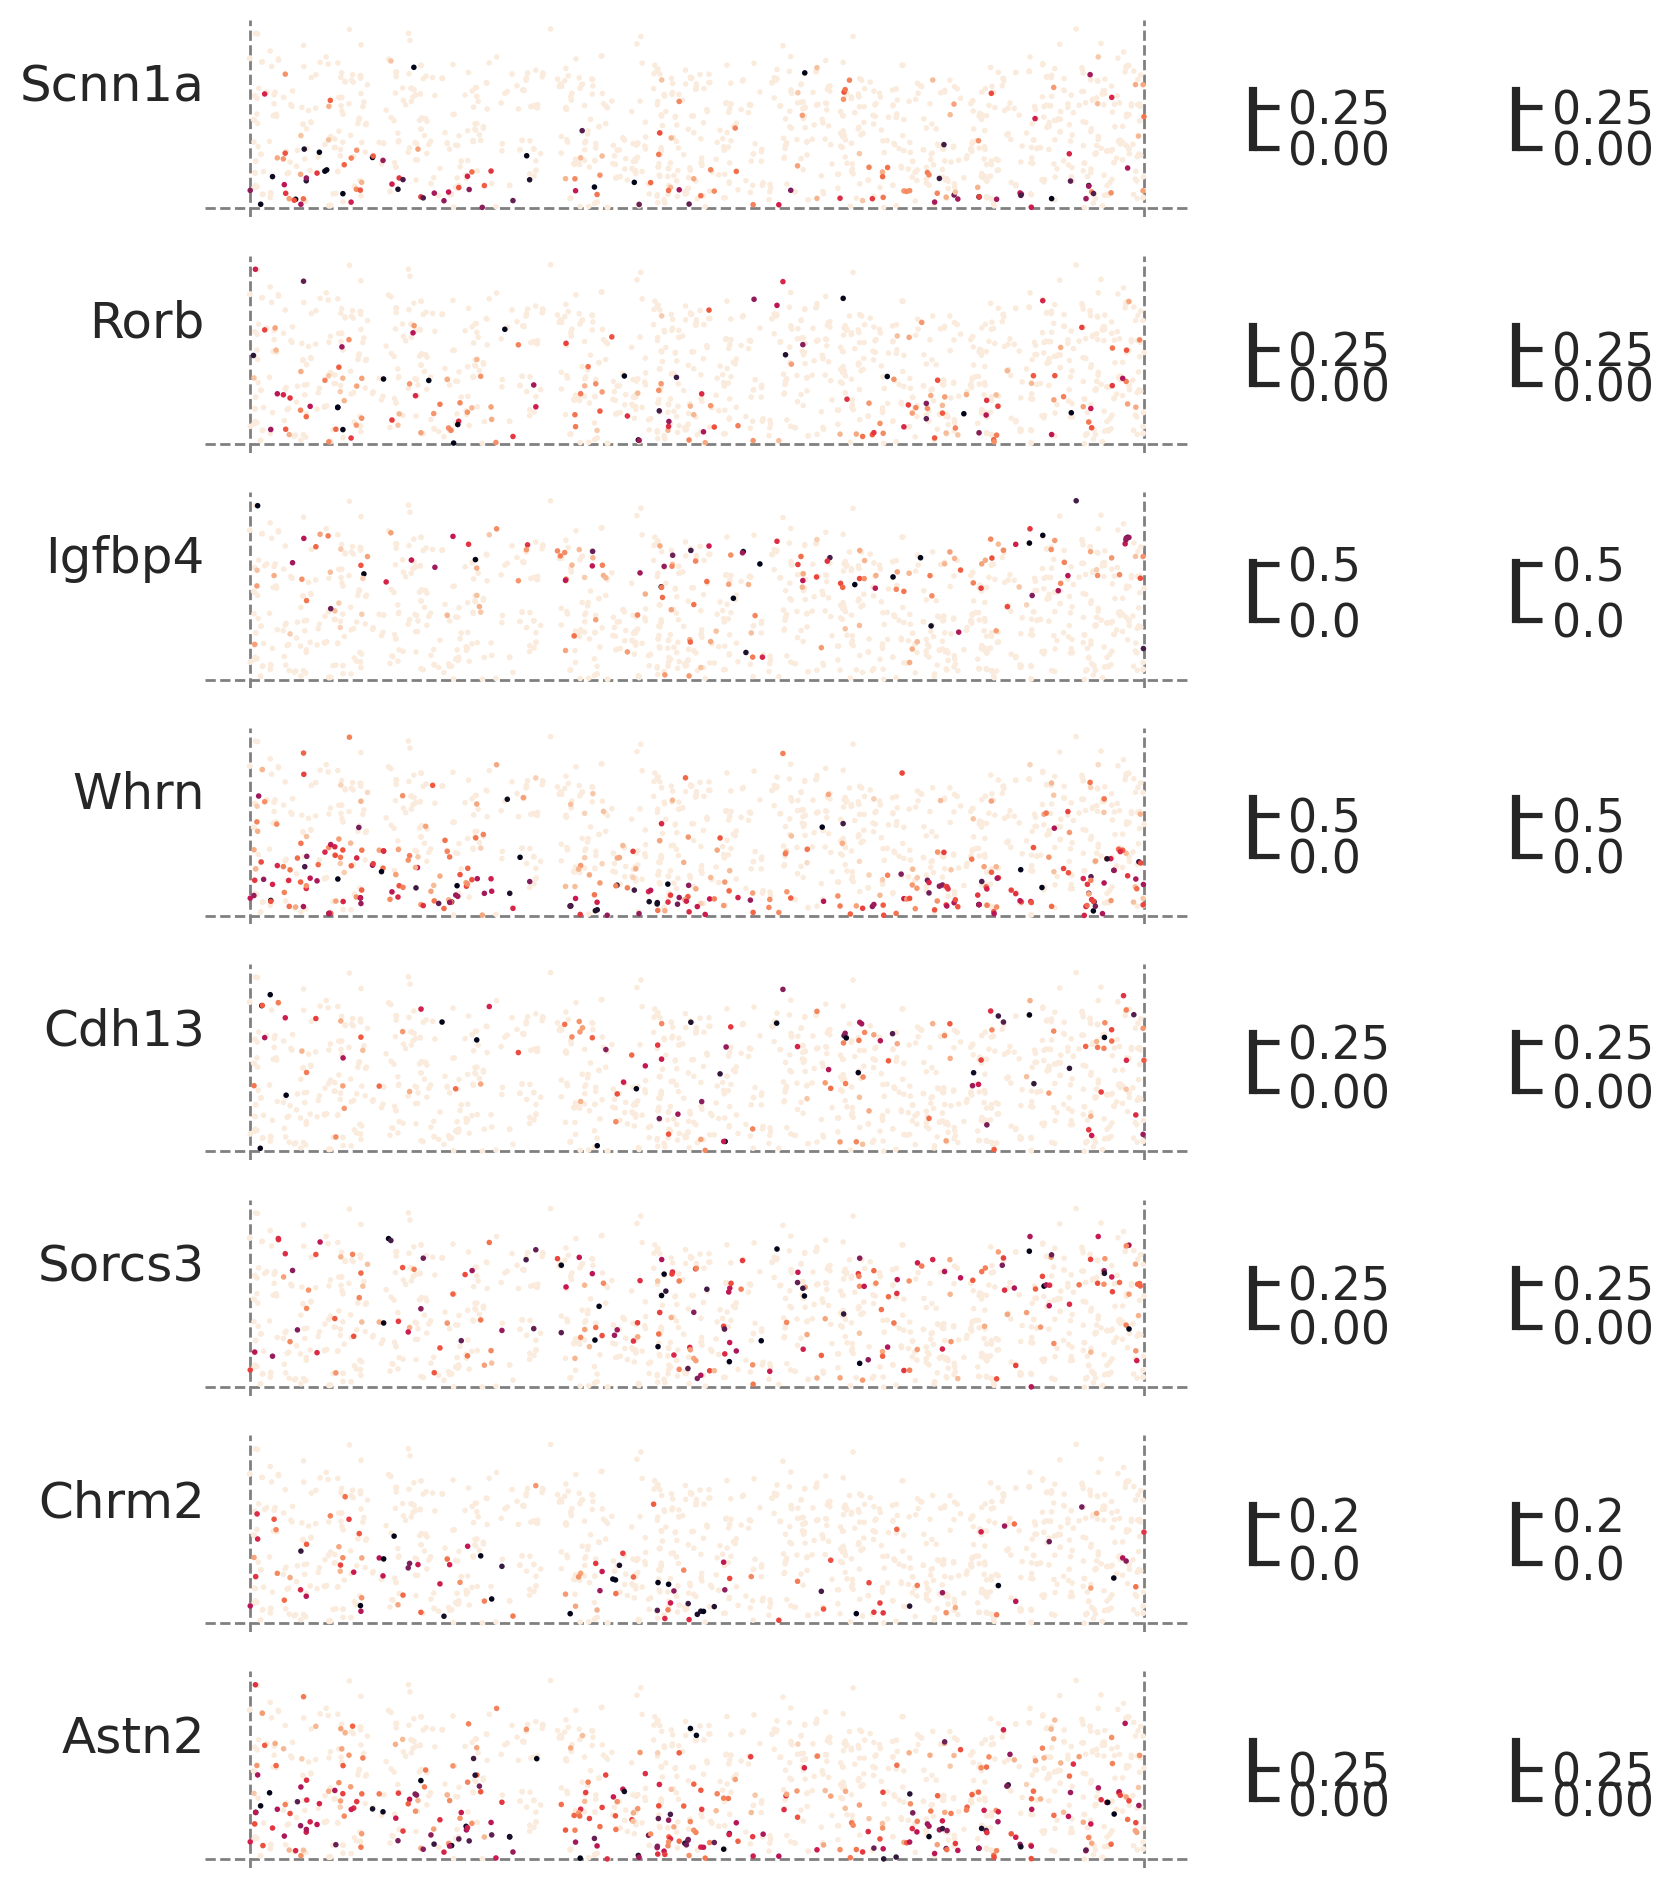

In [12]:
# gns = ['Scnn1a', 'Rorb', 'Igfbp4', 'Whrn', 'Cdh13', 'Sorcs3', 'Chrm2']
x = adatasub.obs['width']
y = -adatasub.obs['depth']
n = len(gns)

fig, axs = plt.subplots(n,1,figsize=(1*10,n*1.5))
for ax, gn in zip(axs, gns):
    # gn = 'Scnn1a'
    g = np.log10(1+adatasub[:,gn].layers['norm']).reshape(-1,)
    
    vmax = np.percentile(g, 99)
    vmin = np.percentile(g,  5)
    cond = g > 1e-5
    
    utils_merfish.st_scatter_ax(fig, ax, x[~cond], y[~cond], gexp=g[~cond], s=4, title='', vmin=vmin, vmax=vmax, cmap='rocket_r') #, axis_off=False)
    utils_merfish.st_scatter_ax(fig, ax,  x[cond],  y[cond],  gexp=g[cond], s=4, title='', vmin=vmin, vmax=vmax, cmap='rocket_r') #, axis_off=False)
    
    ax.set_title(gn, loc='left', ha='right', y=0.5)
    ax.axhline(-bound_d, linestyle='--', linewidth=1, color='gray', zorder=0)
    ax.axvline( bound_l, linestyle='--', linewidth=1, color='gray', zorder=0)
    ax.axvline( bound_r, linestyle='--', linewidth=1, color='gray', zorder=0)
    # ax.grid(True)
    # ax.axis('on')
    
plt.show()

# ABC genes

In [14]:
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/MERFISH_gene_panel_Version1_March9.csv'
df1 = pd.read_csv(f)
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/gene_ptime_P28_L23_Mar27.tsv'
df2 = pd.read_csv(f).sort_values('gene_ptime')
df = pd.merge(df1, df2, left_on='gene_name_data', right_on='gene').sort_values('gene_ptime')
genes_abco = df['gene_name_vizgen'].values
genes_abco.shape

(170,)

In [15]:
agenes = df[df['P17on_x']=='A']['gene_name_vizgen'].values
bgenes = df[df['P17on_x']=='B']['gene_name_vizgen'].values
cgenes = df[df['P17on_x']=='C']['gene_name_vizgen'].values
len(agenes), agenes, len(bgenes), bgenes, len(cgenes), cgenes

(64,
 array(['Met', '6530403H02Rik', 'Rhbdl3', 'Adamts2', 'Cdh13', 'Col23a1',
        'Vwc2l', 'Syt10', 'Kcnn3', 'Arhgef28', 'Pcdh19', 'Pakap', 'Ikzf2',
        'Nckap5', 'Dpyd', 'Gpc5', 'Slc6a7', 'Igsf11', 'Glis3', 'Ttc28',
        'Tenm1', 'Syt17', 'Robo1', 'Sema6a', 'Otof', 'Eda', 'Plxna1',
        'Tox3', 'Itga8', 'Kcnk13', 'Wnt4', 'Sdk2', 'Pdzrn4', 'Plxnd1',
        'Ryr3', 'Necab1', 'Camk2d', 'Iqgap2', 'Pdgfc', 'Gabrg3', 'Dscaml1',
        'Reln', 'Npas3', 'Cntn5', 'Rfx3', 'Grm1', 'Kirrel3', 'Nfib',
        'Fkbp5', 'Zfp608', 'Meis2', 'Mdga1', 'Tiam1', 'Grb14', 'Nkain3',
        'Epha6', 'Cacna1h', 'Pde1a', 'Nr3c2', 'Matn2', 'Tmem150c',
        'Adamts17', 'Ldb2', 'Egfem1'], dtype=object),
 35,
 array(['Grm8', 'Galnt17', 'Epha3', 'Rgs8', 'Sox5', 'Zfp804b', 'Tmeff1',
        'Fstl5', 'Cdh4', 'Kcnip3', 'Myh9', 'Sh3pxd2b', 'Klhl1', 'Trpc6',
        'Sema4a', 'Tafa1', 'Sertm1', 'Nrp1', 'Col26a1', 'Mas1', 'Igfn1',
        'Npas4', 'Scg3', 'Nptx2', 'Bdnf', 'Phf21b', 'Nell1', 'Baz1a',
 

In [16]:
agenes_idx = basicu.get_index_from_array(adatasub.var.index.values, agenes)
bgenes_idx = basicu.get_index_from_array(adatasub.var.index.values, bgenes)
cgenes_idx = basicu.get_index_from_array(adatasub.var.index.values, cgenes)

In [17]:
adatasub.layers['lnorm'] = np.log10(1+adatasub.layers['norm']) # .sum(axis=1)

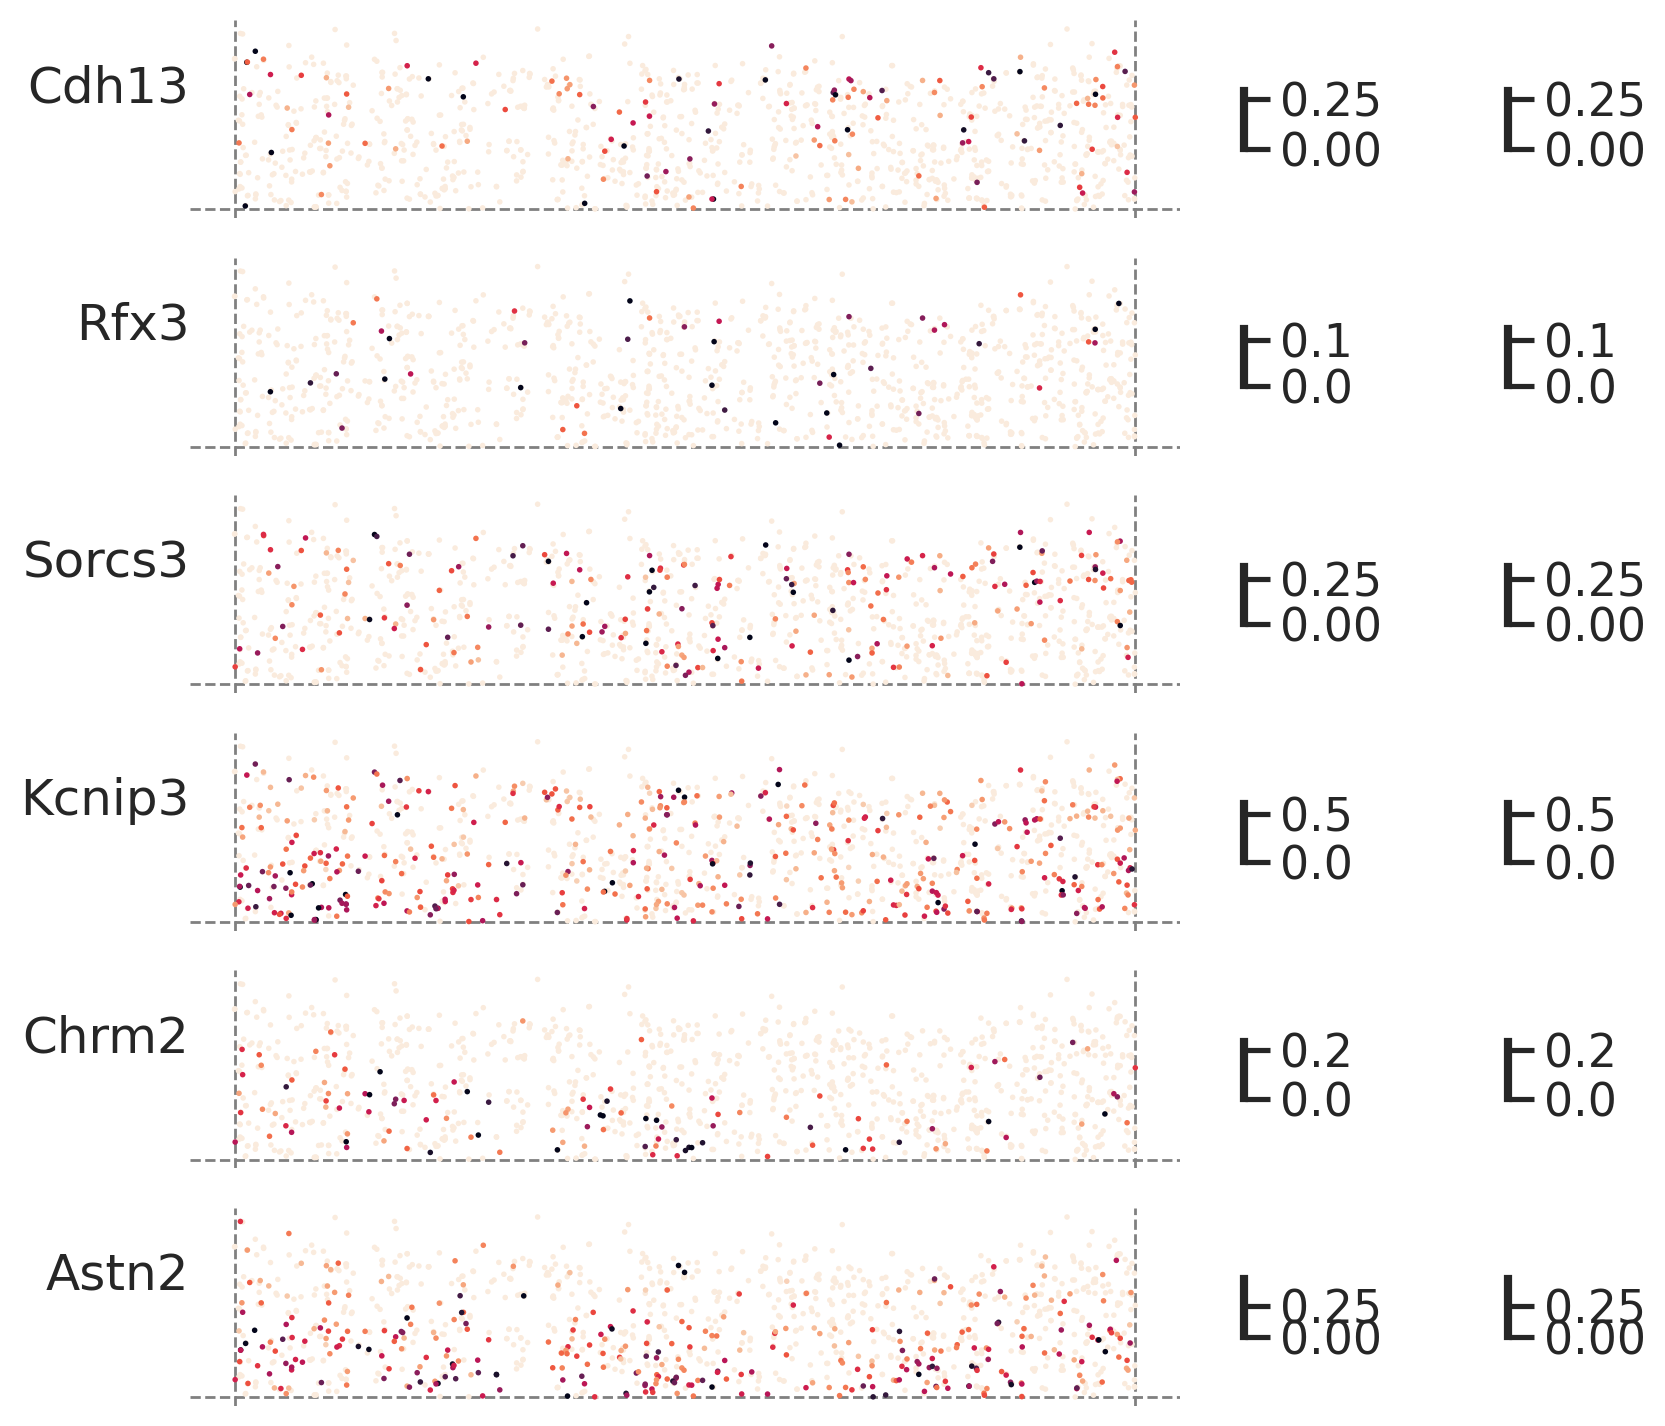

In [18]:
gns = ['Cdh13', 'Rfx3', 'Sorcs3', 'Kcnip3', 'Chrm2', 'Astn2']
x = adatasub.obs['width']
y = -adatasub.obs['depth']
n = len(gns)

fig, axs = plt.subplots(n,1,figsize=(1*10,n*1.5))
for ax, gn in zip(axs, gns):
    # gn = 'Scnn1a'
    g = np.log10(1+adatasub[:,gn].layers['norm']).reshape(-1,)
    
    vmax = np.percentile(g, 99)
    vmin = np.percentile(g,  5)
    cond = g > 1e-5
    
    utils_merfish.st_scatter_ax(fig, ax, x[~cond], y[~cond], gexp=g[~cond], s=4, title='', vmin=vmin, vmax=vmax, cmap='rocket_r') #, axis_off=False)
    utils_merfish.st_scatter_ax(fig, ax,  x[cond],  y[cond],  gexp=g[cond], s=4, title='', vmin=vmin, vmax=vmax, cmap='rocket_r') #, axis_off=False)
    
    ax.set_title(gn, loc='left', ha='right', y=0.5)
    ax.axhline(-bound_d, linestyle='--', linewidth=1, color='gray', zorder=0)
    ax.axvline( bound_l, linestyle='--', linewidth=1, color='gray', zorder=0)
    ax.axvline( bound_r, linestyle='--', linewidth=1, color='gray', zorder=0)
    # ax.grid(True)
    # ax.axis('on')
    
plt.show()

# stats

In [19]:
lnorm_mean, lnorm_sem, lnorm_std, n, d, w, db, wb = binning_pipe(adatasub, n=10)
d.value_counts()

/tmp/ipykernel_12276/773494810.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  norm_mean = norm_.groupby(bin_type).mean()
/tmp/ipykernel_12276/773494810.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  norm_sem  = norm_.groupby(bin_type).sem()
/tmp/ipykernel_12276/773494810.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  norm_std  = norm_.groupby(bin_type).std()


(0.0, 44.406]          13
(44.406, 88.813]       48
(88.813, 133.219]     137
(133.219, 177.625]    184
(177.625, 222.031]    129
(222.031, 266.438]    163
(266.438, 310.844]    177
(310.844, 355.25]     175
(355.25, 399.657]     164
dtype: int64

In [20]:
tmp = lnorm_mean.iloc[:,agenes_idx].copy()
am = np.mean(tmp, axis=0) # across depth bins
amean = (tmp - am).mean(axis=1) # across genes

tmp = lnorm_mean.iloc[:,bgenes_idx].copy()
bm = np.mean(tmp, axis=0)
bmean = (tmp - bm).mean(axis=1)

tmp = lnorm_mean.iloc[:,cgenes_idx].copy()
cm = np.mean(tmp, axis=0)
cmean = (tmp - cm).mean(axis=1)

# sem
tmp2 = lnorm_sem.iloc[:,agenes_idx].copy()
asem = tmp2.mean(axis=1)

tmp2 = lnorm_sem.iloc[:,bgenes_idx].copy()
bsem = tmp2.mean(axis=1)

tmp2 = lnorm_sem.iloc[:,cgenes_idx].copy()
csem = tmp2.mean(axis=1)

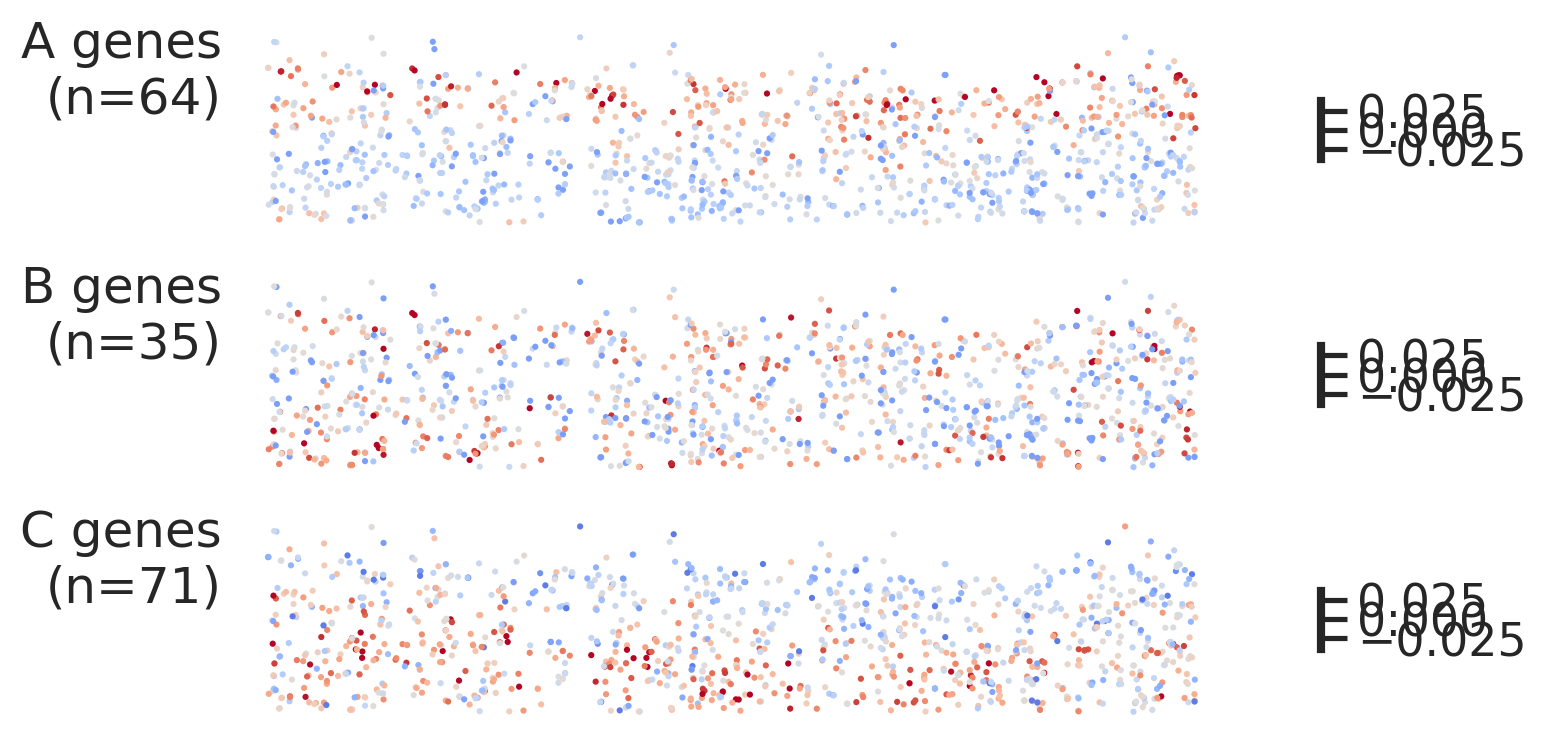

In [21]:
depth = adatasub.obs['depth'].values
width = adatasub.obs['width'].values
mat   = adatasub.layers['lnorm']

# x, y, _ = utils_merfish.get_xyg(adata, 'Cdh13', 'norm')
# xr, yr = rot2d(x, y, theta)
                                
fig, axs = plt.subplots(3,1,figsize=(10,3*1.5))
gnames = ['A genes\n(n=64)', 'B genes\n(n=35)', 'C genes\n(n=71)']
for i, (_idx, _baseline) in enumerate(zip([agenes_idx, bgenes_idx, cgenes_idx], 
                                        [am, bm, cm])):
    ax = axs[i]
    lnorm_ = mat[:,_idx].copy()
    g = (lnorm_ - np.array(_baseline).reshape(1,-1)).mean(axis=1) 
    gn = gnames[i]
    vmax = +0.04 # np.percentile(g, 95)
    vmin = -0.04 # np.percentile(g,  0)
    
    utils_merfish.st_scatter_ax(fig, ax, width, -depth, gexp=g, s=5, title='', vmin=vmin, vmax=vmax, cmap='coolwarm') #, axis_off=False)
    ax.set_title(gn, loc='left', ha='right', y=0.5)
plt.show()

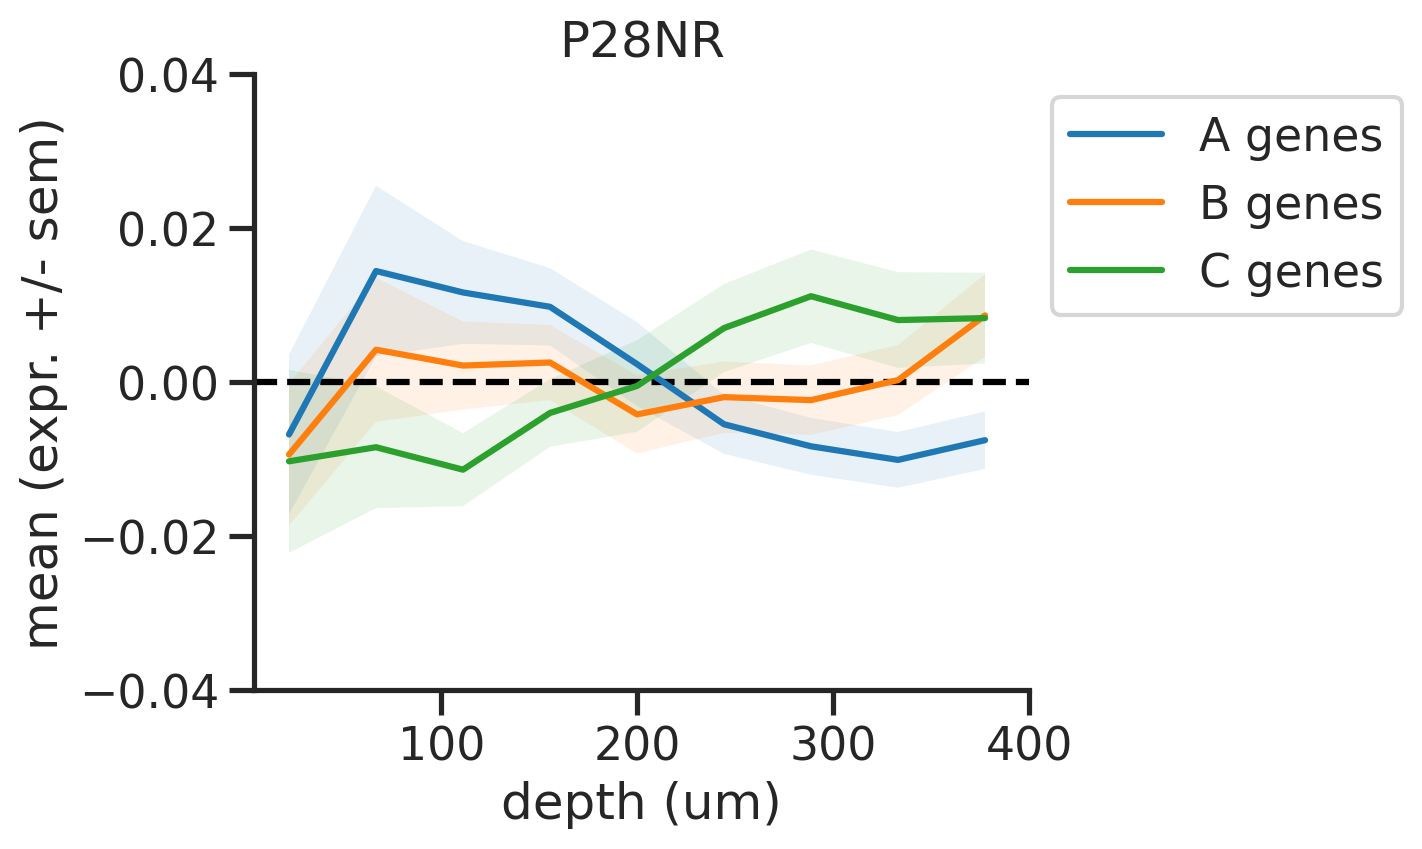

In [22]:
gnames = ['A genes (n=64)', 'B genes (n=35)', 'C genes (n=71)']
x = np.mean(np.vstack([db[:-1], db[1:]]), axis=0)

fig, ax = plt.subplots(1, 1, figsize=(5*1,4), sharex=True, sharey=True)

ax.plot(x, amean, label='A genes', color='C0', linestyle='-')
ax.fill_between(x, amean-asem, amean+asem, color='C0', alpha=0.1, edgecolor='none')
ax.plot(x, bmean, label='B genes', color='C1', linestyle='-')
ax.fill_between(x, bmean-bsem, bmean+bsem, color='C1', alpha=0.1, edgecolor='none')
ax.plot(x, cmean, label='C genes', color='C2', linestyle='-')
ax.fill_between(x, cmean-csem, cmean+csem, color='C2', alpha=0.1, edgecolor='none')
ax.axhline(color='k', linestyle='--', zorder=1)
    
ax.legend(bbox_to_anchor=(1,1))
sns.despine(ax=ax)
ax.set_title('P28NR')
ax.set_xlabel('depth (um)')


ax.set_ylim([-0.04, 0.04])
ax.grid(False)
    
ax.set_xlim(xmax=400)
ax.set_ylabel('mean (expr. +/- sem)')
fig.subplots_adjust(wspace=0.1)
# powerplots.savefig_autodate(fig, outdatadir+'/grant_saumya_lineq_abc_v3.pdf')

In [23]:
# compare two states